In [18]:
import ee
import geemap
import os
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from functions_floes import *
import earthaccess
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geemap
import xarray as xr
import h5netcdf
import pickle

## Read ice drift files

In [37]:
sub = "EW"
files = glob.glob(f"D:\\Floes\\ice_vel\\pickle\\S1_{sub}*.pkl")

In [46]:
df = pd.DataFrame()

for i, f in enumerate(files):
    d1 = os.path.basename(f).split("_")[3]
    d2 = os.path.basename(f).split("_")[4][:-4]
    t1 = datetime.strptime(d1, "%Y%m%dT%H%M%S")
    t2 = datetime.strptime(d2, "%Y%m%dT%H%M%S")

    df.loc[i, "d1"] = t1
    df.loc[i, "d2"] = t2

    ts = abs(t1 - t2).total_seconds() / 3600

    with open(f, 'rb') as object:
        [upm, vpm, apm, rpm, hpm, lon2pm, lat2pm] = pickle.load(object)
        upm[rpm < 0.3] = np.nan
        vpm[rpm < 0.3] = np.nan

    df.loc[i, "vel_mean"] = np.nanmean((upm**2 + vpm**2)**0.5) / ts
    df.loc[i, "vel_med"] = np.nanmedian((upm**2 + vpm**2)**0.5) / ts
    df.loc[i, "vel_max"] = np.nanmax((upm**2 + vpm**2)**0.5) / ts
    df.loc[i, "vel_min"] = np.nanmin((upm**2 + vpm**2)**0.5) / ts
    df.loc[i, "vel_std"] = np.nanstd((upm**2 + vpm**2)**0.5) / ts

df.to_csv(f"D:\\Floes\\ice_vel\\Vel_{sub}.csv")

In [42]:
t1 = datetime.strptime(d1, "%Y%m%dT%H%M%S")
t2 = datetime.strptime(d2, "%Y%m%dT%H%M%S")

In [49]:
df = pd.read_csv(f"D:\\Floes\\ice_vel\\Vel_{sub}_with_trace.csv",index_col = 0)
df['d1'] = pd.to_datetime(df['d1'])
df['d2'] = pd.to_datetime(df['d2'])

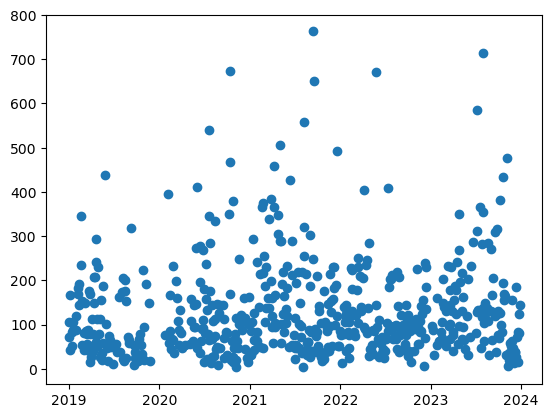

In [52]:
plt.scatter(df['d1'], df['vel_med'])

In [115]:
df2 = pd.DataFrame()

if df.loc[0, "trace"] == 1:
    idxes = [0]
else:
    idxes = []

for i in range(1, len(df)):
    if (df.loc[i, "trace"] == 1) & (df.loc[i-1, "trace"] == 0):
        idxes.append(i)
        # k = 1
        # while df.loc[i+k, "trace"] == 1:
        #     k += 1
        # df0 = df.loc[i:i+k]
        # df2 = pd.concat([df2, df0.mean()])

df2 = df.copy()
df2["trace2"] = 0
df2.loc[idxes, "trace2"] = 1

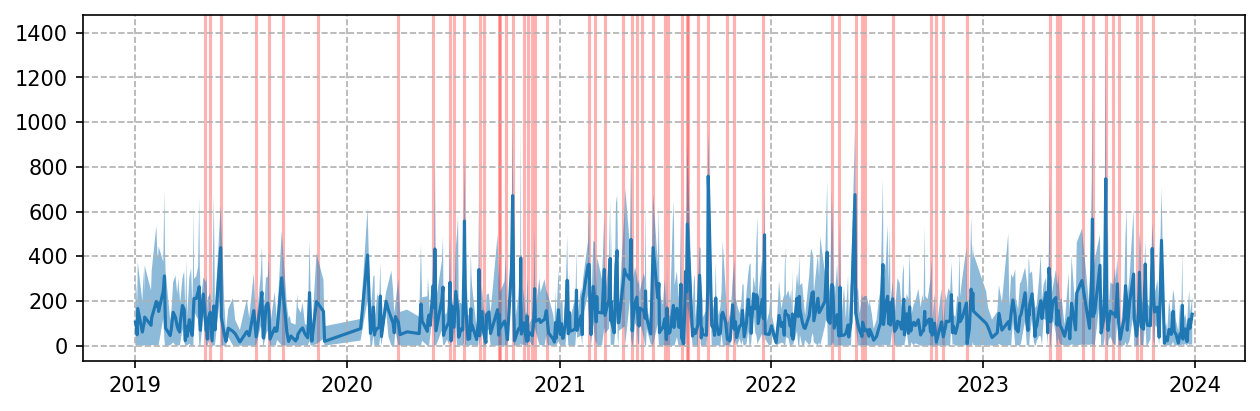

In [130]:
plt.figure(figsize = (10, 3), dpi = 150)
plt.fill_between(df2['d1'], df2['vel_max'], df2['vel_min'], alpha = 0.5)
plt.plot(df2['d1'], df2['vel_mean'])
# plt.plot(df2['d1'], df2['vel_min'])
dates = df2.loc[df2['trace2'] == 1, 'd2'].values

for d in dates:
    plt.axvline(x = d, color = "r", alpha = 0.3, zorder= 0)
plt.grid(ls = "--")

In [116]:
df2

,d1,d2,vel_mean,vel_med,vel_max,vel_min,vel_std,trace,trace2
0,2019-01-01 01:49:00,2019-01-03 01:33:00,105.530586,104.594028,307.020636,1.047565,67.969138,0,0
1,2019-01-03 01:33:00,2019-01-04 00:36:00,77.739267,72.106594,241.899069,0.000000,33.955250,0,0
2,2019-01-04 00:36:00,2019-01-05 01:17:00,48.882642,41.771769,178.779495,2.026228,26.996042,0,0
3,2019-01-05 01:17:00,2019-01-06 01:57:00,166.038258,165.832920,374.466184,2.865584,47.498171,0,0
4,2019-01-13 01:49:00,2019-01-15 01:33:00,60.751718,51.159680,198.287304,1.047571,35.083758,0,0
...,...,...,...,...,...,...,...,...,...
569,2023-12-18 01:50:00,2023-12-20 01:34:00,18.480942,15.713571,88.151747,0.000000,12.589298,0,0
570,2023-12-20 01:34:00,2023-12-22 01:17:00,87.090454,83.810100,190.938327,9.658637,29.038242,0,0
571,2023-12-22 01:17:00,2023-12-23 01:58:00,117.952316,123.868171,248.505801,2.865584,40.666758,0,0
572,2023-12-23 01:58:00,2023-12-27 01:25:00,77.613102,79.892503,140.913670,5.468435,20.503461,0,0


In [119]:
data = [df.loc[df['trace']==0, 'vel_med'].values/24, df2.loc[df2['trace']==1, 'vel_med'].values/24]

Text(0, 0.5, 'Ice velocity (km/day)')

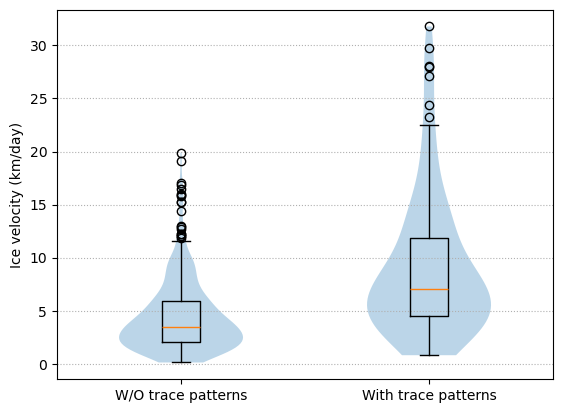

In [120]:
# plot violin plot
plt.violinplot(data,showextrema=False)

plt.boxplot(data)
plt.xticks([1,2],labels=['W/O trace patterns', 'With trace patterns'])
plt.grid(axis='y', ls = ":")
# plt.yscale('log')
plt.ylabel("Ice velocity (km/day)")

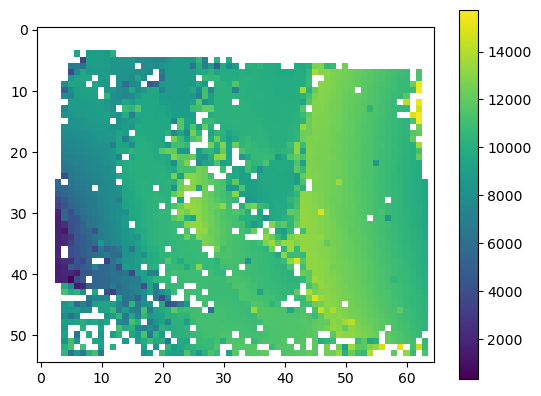

In [31]:
plt.imshow((upm**2 + vpm**2)**0.5)
plt.colorbar()

In [31]:
region = ee.Geometry.BBox(-51, -78.5, -41, -76.5) # Landfast ice in the Weddell Sea

# Mukund's ROI
bbox = [-10, 72.6, 12, 79.2]
# bbox = [-176.3, -76.3, -153.9, -74.4]
region = ee.Geometry.BBox(bbox[0], bbox[1], bbox[2], bbox[3]) #ee.Geometry.Rectangle(bbox)
point = ee.Geometry.Point([np.mean([bbox[0], bbox[2]]), np.mean([bbox[1], bbox[3]])]).buffer(20000)
# Approximately (72.6 to 79.2 N) and (-10 to 12 E) April to May 2023
# Approximately (-76.3 to -74.4 S) and (-176.3 to -153.9 W) November - December 2023

# Grounded icebergs ROI
sub = "W" #"EW"

if sub == "EW":
    point = [-45.14, -76.6] # South Weddell
    offset = [3, 0.6]
elif sub == "W":
    point = [-58.4,-71.23] # West Weddell
    offset = [1.75, 0.60]
else:
    print("SET SUBAREA!! (E or EW)")
    
bbox = [point[0]-offset[0], point[1]-offset[1], point[0]+offset[0], point[1]+offset[1]]
region = ee.Geometry.Point(point).buffer(50000)
region = ee.Geometry.BBox(bbox[0], bbox[1], bbox[2], bbox[3])


# point = ee.Geometry.Point([-46, -77.5])

collection = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filter(ee.Filter.eq('transmitterReceiverPolarisation', ["HH"]))\
.filterBounds(region)
# .filter(ee.Filter.Or(ee.Filter.eq('relativeOrbitNumber_start', 5), ee.Filter.eq('relativeOrbitNumber_start', 34),
#         ee.Filter.eq('relativeOrbitNumber_start', 136)))

# 2016: 165
# 2017: 5

## Load ICESat-2 (via Earthacess) for the overlapped date

In [8]:
import earthaccess
auth = earthaccess.login(persist=True)

In [32]:
date = "20221012"
img_files = glob.glob(f"D:\\Floes\\S1_ground\\S1*_{sub}_*{date}*.tif")

for k, f in enumerate(img_files[:]): #glob.glob("D:\\Floes\\S1_ground\\*.tif"):
    # os.rename(f, f.replace(" .tif", ".tif"))

    dh = 12 # hour difference between S1 and IS2
    
    basename = os.path.basename(f)
    t1 = datetime.strptime(basename[-19:-4], "%Y%m%dT%H%M%S") - timedelta(seconds = 3600*dh)
    t2 = datetime.strptime(basename[-19:-4], "%Y%m%dT%H%M%S") + timedelta(seconds = 3600*dh)

    t1_str = datetime.strftime(t1, "%Y%m%d T%H%M%S")
    t2_str = datetime.strftime(t2, "%Y%m%d T%H%M%S")

    Query = earthaccess.granule_query().concept_id('C2613553243-NSIDC_CPRD')\
    .temporal(t1_str, t2_str).bounding_box(bbox[0], bbox[1], bbox[2], bbox[3])

    N = Query.hits()
    granules = Query.get(N)
    is2_file = earthaccess.open(granules)[-1]
    
    # if os.path.exists(imgname):
    start_time = datetime.strftime(t1, "%Y-%m-%d T%H:%M:%S")
    # end_time = datetime.strftime(t2, "%Y-%m-%d T%H:%M:%S")

    proceed = False

    if N > 0:
    
        if sub == "EW":
            dstCrs = {'init': 'EPSG:32723'}
        elif sub == "W":
            dstCrs = {'init': 'EPSG:32721'}
    
        ## Read Sentinel-1 SAR image using raterio ====================================
        img = rasterio.open(f)
        array = img.read(1)
        
        height = array.shape[0]
        width = array.shape[1]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    
        transform, width, height = calculate_default_transform(img.crs, dstCrs, img.width, img.height, *img.bounds)
        
        # XY projected coordinate of the image
        xs, ys = rasterio.transform.xy(transform, rows, cols)           
        
        xs = np.array(xs)
        ys = np.array(ys)
        # print(img.crs)
    
        img.close()
        # ===========================================================================

        print(start_time, basename, is2_file.url)

        ## ICESat-2 data using Earthaccess ===========================================
        df = read_ATL10(is2_file, bbox)

        # Convert pandas dataframe into geopandas geodataframe
        gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))
        # Assign crs information into geodatafraem
        gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
        
        # Convert crs of the geodataframe into the crs of the Sentinel-2 image
        gdf = gdf.to_crs(dstCrs['init'])
        
        gdf['x'] = gdf.geometry.apply(lambda x: x.x)
        gdf['y'] = gdf.geometry.apply(lambda x: x.y)

print("Done!")

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

2022-10-11 T12:14:33 S1A_W_GRDH_1SSH_20221012T001433.tif https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2022/10/11/ATL10-02_20221011205843_03231701_006_01.h5
Done!


In [33]:
beams = pd.unique(gdf['beam'])
gdf2 = gdf[gdf['beam'] == beams[0]].reset_index(drop = True)
gdf2.head(5)

,beam,lat,lon,seg_x,seg_len,fb,ph_rate,sigma,stype,refsur_ndx,sample_ndx,fb_std,fb_mode,ridge,geometry,x,y
0,gt1r,-71.829986,-58.465908,0.000000,14.167957,0.206804,6.714286,0.016421,1,37,370.0,NaN,0.334,0.0,POINT (448983.476 2029410.785),448983.475560,2.029411e+06
1,gt1r,-71.829917,-58.465938,7.847964,14.874374,0.217141,6.409091,0.014921,1,37,370.0,0.045443,0.334,0.0,POINT (448982.254 2029418.534),448982.254390,2.029419e+06
2,gt1r,-71.829860,-58.465962,14.221490,14.165565,0.290172,6.809524,0.020745,1,37,370.0,0.098037,0.334,0.0,POINT (448981.265 2029424.827),448981.265310,2.029425e+06
3,gt1r,-71.829799,-58.465987,21.072570,12.751307,0.411243,7.315790,0.030744,1,37,370.0,0.079842,0.334,0.0,POINT (448980.204 2029431.592),448980.204085,2.029432e+06
4,gt1r,-71.829754,-58.466006,26.156281,11.329750,0.260538,7.764706,0.028138,1,37,370.0,0.077481,0.334,0.0,POINT (448979.418 2029436.613),448979.417858,2.029437e+06


NameError: name 'xs' is not defined

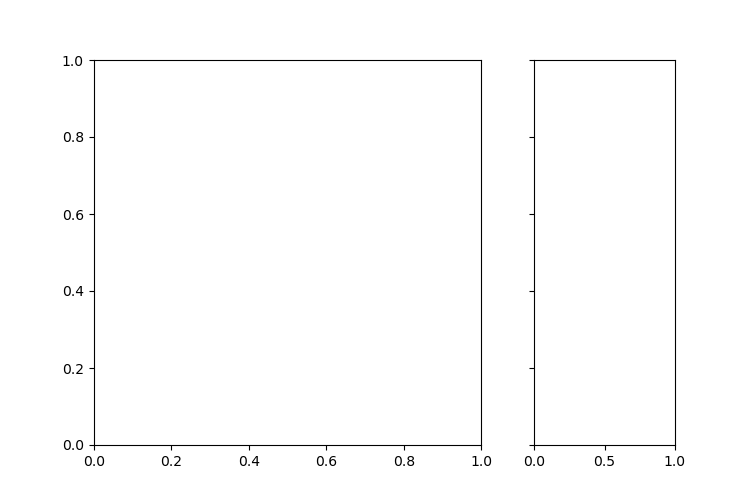

In [131]:
%matplotlib widget

fig, ax = plt.subplots(1,2, figsize = (7.5,5), gridspec_kw={'width_ratios': [5.5,2]},sharey = True)

ax[0].pcolormesh(xs, ys, array, cmap = "Greys_r", vmin = -0.5, vmax = -0.1)
t = ax[0].annotate(f"{start_time}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=12)
t.set_bbox(dict(facecolor='white', alpha=0.5))
# ax[0].set_xlim(420000, 540000)
# ax[0].set_ylim(1440000, 1560000)

ax[0].scatter(gdf2['x'], gdf2['y'], c = gdf2['fb'], s = 2, vmin = 0, vmax = 1, cmap = "jet")

ax[1].plot(gdf2['fb'], gdf2['y'], '.')
ax[1].set_xlim(0, 2.5)
is2_time = datetime.strptime(os.path.basename(is2_file.url)[9:23], "%Y%m%d%H%M%S")
is2_str = is2_time.strftime("%Y-%m-%d T%H:%M:%S")
ax[1].set_title(f"{is2_str}", fontsize=10)

In [33]:
is2_time.strftime("%Y-%m-%d T%H:%M:%S")

'2020-10-13 T17:56:41'

In [16]:
from tkinter import *
from tkinter import ttk

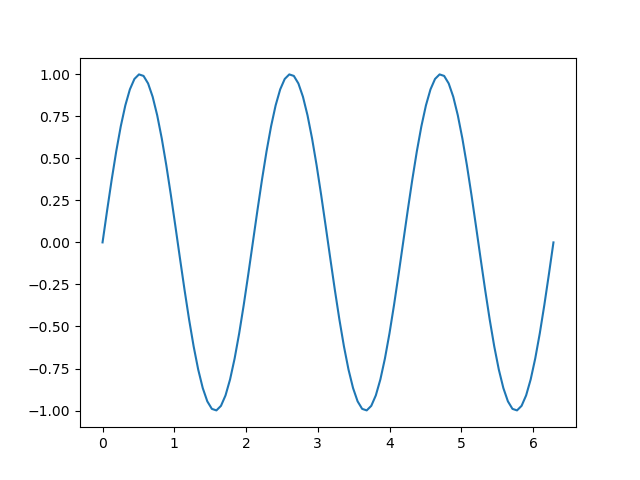

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,1)
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(3*x)
plt.plot(x, y)

In [6]:
%matplotlib widget